## Jialin Shi  --  Breast Cancer Diagnosis

### Semi-supervised Learning -(Only 50% of the train data has been labeled.)
###### Method:
Train an L1-penalized SVM to classify the labeled data.     
Choose the penalty parameter using 5 fold cross validation.

Fit with unlabeled data.       
Find the farthest unlabeled data point to the decision boundary of the SVM.    
Let SVM label it and add it back to labeled data. Then retrain SVM.  
Continue this process until all unlabeled data are used. 



###### Monte Carlo Simulation: 
te_accuray : 0.954     
te_precision : 0.908    
te_recall : 0.950      
te_roc : 0.950     
te_fscore : 0.951   

A bit lower than supervised learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split  # split data for training and testing
from sklearn.preprocessing import StandardScaler      # standardScaler,uniformed
from sklearn.metrics import confusion_matrix                         
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import hamming_loss
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import SpectralClustering

In [2]:
# (a) Load the Vertebral Column Data Set from
# Benign=B-neg, Malignant=M-pos
df= pd.read_csv('wdbc.data.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Semi-Supervised Learning/ Self-training:

In [21]:
pos=df[df[1]=='M']
neg=df[df[1]=='B']

In [22]:
#split pos data into train and test
pos_train,pos_test=train_test_split(pos,test_size=0.2)

#split train into label and unlabel
label_tr,unlabel_tr=train_test_split(pos_train,test_size=0.5)

label_try=label_tr.iloc[:,1]
label_trx=label_tr.iloc[:,2:]
unlabel_trx=unlabel_tr.iloc[:,2:]
pos_testx=pos_test.iloc[:,2:]


#split pos data into train and test
neg_train,neg_test=train_test_split(neg,test_size=0.2)

#split train into label and unlabel
laneg_tr,unneg_tr=train_test_split(neg_train,test_size=0.5)

laneg_try=laneg_tr.iloc[:,1]
laneg_trx=laneg_tr.iloc[:,2:]
unneg_trx=unneg_tr.iloc[:,2:]
neg_testx=neg_test.iloc[:,2:]


pos_testy=pos_test.iloc[:,1]
neg_testy=neg_test.iloc[:,1]
testy=pd.concat([pos_testy,neg_testy])

#concat
testx=pd.concat([pos_testx,neg_testx])
train_lax=pd.concat([label_trx,laneg_trx])
train_unx=pd.concat([unlabel_trx,unneg_trx])
trainy=pd.concat([label_try,laneg_try])

# Normalize data
transformer = Normalizer().fit(train_lax)
train_lax=transformer.transform(train_lax)
testx=transformer.transform(testx)
train_unx=transformer.transform(train_unx)


In [23]:
# Set the parameters by cross-validation
tuned_parameters = [{'tol': [1e1,1e0,1e-1,1e-2,1e-3,1e-4],
                     'C': [1, 10, 100, 1000,10000,100000]}]

#build model
LSVC=LinearSVC(penalty='l1',dual=False)
clf = GridSearchCV(LSVC, tuned_parameters, cv=5)
clf.fit(train_lax,trainy)
print(clf.best_params_)
h=clf.best_params_
bestC=h['C']
tol0=h['tol']


{'C': 10000, 'tol': 0.01}


#### Monte Carlo Simulation for M=30

In [25]:
te_accuray=[]
tr_accuray=[]
te_precision=[]
tr_precision=[]
te_recall=[]
tr_recall=[]
te_roc=[]
tr_roc=[]
te_fscore=[]
tr_fscore=[]

for a in range(30):
    pos_train,pos_test=train_test_split(pos,test_size=0.2)

    #split train into label and unlabel
    label_tr,unlabel_tr=train_test_split(pos_train,test_size=0.5)

    label_try=label_tr.iloc[:,1]
    label_trx=label_tr.iloc[:,2:]
    unlabel_trx=unlabel_tr.iloc[:,2:]
    pos_testx=pos_test.iloc[:,2:]


    #split pos data into train and test
    neg_train,neg_test=train_test_split(neg,test_size=0.2)

    #split train into label and unlabel
    laneg_tr,unneg_tr=train_test_split(neg_train,test_size=0.5)

    laneg_try=laneg_tr.iloc[:,1]
    laneg_trx=laneg_tr.iloc[:,2:]
    unneg_trx=unneg_tr.iloc[:,2:]
    neg_testx=neg_test.iloc[:,2:]


    pos_testy=pos_test.iloc[:,1]
    neg_testy=neg_test.iloc[:,1]
    testy=pd.concat([pos_testy,neg_testy])

    #concat
    testx=pd.concat([pos_testx,neg_testx])
    train_lax=pd.concat([label_trx,laneg_trx])
    train_unx=pd.concat([unlabel_trx,unneg_trx])
    trainy=pd.concat([label_try,laneg_try])

    # Normalize data
    transformer = Normalizer().fit(train_lax)
    train_lax=transformer.transform(train_lax)
    testx=transformer.transform(testx)
    train_unx=transformer.transform(train_unx)
    
    LSVC=LinearSVC(penalty='l1',dual=False)
    clf = GridSearchCV(LSVC, tuned_parameters, cv=5)
    clf.fit(train_lax,trainy)
    h=clf.best_params_
    bestC=h['C']
    tol0=h['tol']
    
    for i in range(len(train_unx)):
        clf =LinearSVC(penalty='l1',dual=False,C=bestC,tol=tol0)
        clf.fit(train_lax, trainy)
        confidence=clf.decision_function(train_unx)

        # find highest confidence
        index=np.where(confidence==np.max(confidence))[0][0]

        # transform new data
        train_unx=pd.DataFrame(train_unx)
        new_data=pd.DataFrame(train_unx.iloc[index,:]).T
        new_data.columns=range(30)

        # concat new labeled train set
        train_lax=pd.DataFrame(train_lax)
        train_lax=pd.concat([train_lax,new_data])

        # predict label for new data
        pred=clf.predict(new_data)

        # transform new label
        pred=pd.DataFrame(pred)
        pred.columns=[1]

        # concat new labels
        trainy=pd.DataFrame(trainy) 
        trainy=pd.concat([trainy,pred])

        # drop new data from unlabeled data
        train_unx=train_unx.drop(index=train_unx.iloc[index:index+1,:].index[0])

    #accuracy
    pred_final=clf.predict(testx)
    predt=clf.predict(train_lax)
    test_accuray=1-hamming_loss(testy, pred_final)
    train_accuray=1-hamming_loss(trainy, predt)
    te_accuray.append(test_accuray)
    tr_accuray.append(train_accuray)

    # make it binary
    testy2=testy.replace({'M':1,'B':-1})
    pred_final=pd.DataFrame(pred_final)
    pred2=pred_final.replace({'M':1,'B':-1})

    trainy2=trainy.replace({'M':1,'B':-1})
    pred0=pd.DataFrame(predt)
    pred3=pred0.replace({'M':1,'B':-1})

    #precision
    average_precision = average_precision_score(testy2, pred2)
    average_precision0 = average_precision_score(trainy2, pred3)
    test_precision=average_precision
    train_precision=average_precision0
    te_precision.append(test_precision)
    tr_precision.append(train_precision)

    # recall
    test_recall=recall_score(testy2, pred2, average='macro')
    train_recall=recall_score(trainy2, pred3, average='macro')
    te_recall.append(test_recall)
    tr_recall.append(train_recall)

    # f score
    test_fscore=f1_score(testy2, pred2, average='macro')
    train_fscore=f1_score(trainy2, pred3, average='macro')
    te_fscore.append(test_fscore)
    tr_fscore.append(train_fscore)

    # auc
    a=roc_auc_score(trainy2, pred3)
    tr_roc.append(a)
    b=roc_auc_score(testy2, pred2)
    te_roc.append(b)



 for train auc:


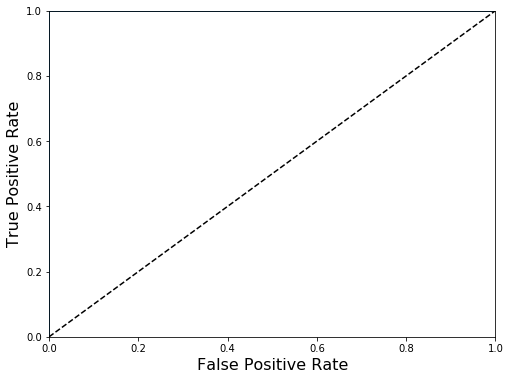

In [26]:
fpr, tpr, thresholds = roc_curve(trainy2, pred3)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
print('\n for train auc:')
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
print('train auc:')
roc_auc_score(trainy2, pred3)

train auc:


1.0


for test auc:


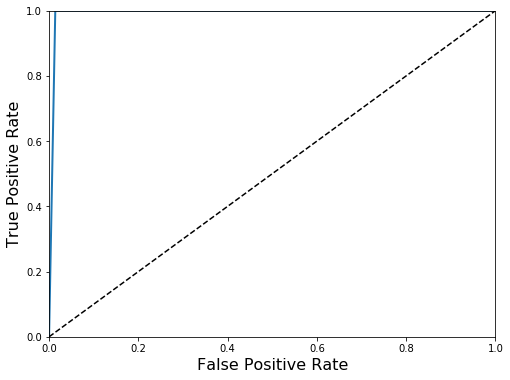

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testy2, pred2)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
print('\nfor test auc:')
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
print('test auc:')
roc_auc_score(testy2, pred2)

test auc:


0.9930555555555556

In [30]:
print("for train:")
confusion_matrix(trainy2, pred3)

for train:


array([[288,   0],
       [  0, 166]])

In [31]:
print("for test:")
confusion_matrix(testy2, pred2)

for test:


array([[71,  1],
       [ 0, 43]])

In [32]:
print('te_accuray :',np.mean(te_accuray))
print('tr_accuray :',np.mean(tr_accuray))
print('tr_precision :',np.mean(tr_precision))
print('te_precision :',np.mean(te_precision))
print('te_recall :',np.mean(te_recall))
print('tr_recall :',np.mean(tr_recall))
print('te_roc :',np.mean(te_roc))
print('tr_roc :',np.mean(tr_roc))
print('te_fscore :',np.mean(te_fscore))
print('tr_fscore :',np.mean(tr_fscore))


te_accuray : 0.9547826086956521
tr_accuray : 0.9917033773861968
tr_precision : 0.9836948322384454
te_precision : 0.908776220162915
te_recall : 0.950462962962963
tr_recall : 0.990754325181408
te_roc : 0.950462962962963
tr_roc : 0.990754325181408
te_fscore : 0.9515714980207569
tr_fscore : 0.991215329163799
